## Task 1 : Data Preparation and Introduction

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler

try:
    df = pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn.csv')
except FileNotFoundError:
    print("Error: Dataset file not found. Please ensure 'WA_Fn-UseC_-Telco-Customer-Churn.csv' is in the directory.")

###  Data Description

In [4]:
print("DataFrame Shape:", df.shape)
print("\nColumn Information:")
df.info()

DataFrame Shape: (7043, 21)

Column Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object

### Data Cleaning

In [5]:
# Convert 'TotalCharges' to numeric, coercing errors to NaN
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

### Handling Missing Values

In [6]:
# Check for missing values
print("\nMissing Values Count:")
print(df.isnull().sum())

# Handle missing 'TotalCharges' (usually about 11 rows)
# Since tenure is 0 for these, it's appropriate to fill with 0.
df['TotalCharges'].fillna(0, inplace=True)


Missing Values Count:
customerID           0
gender               0
SeniorCitizen        0
Partner              0
Dependents           0
tenure               0
PhoneService         0
MultipleLines        0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        11
Churn                0
dtype: int64


/tmp/ipykernel_14178/1403078320.py:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['TotalCharges'].fillna(0, inplace=True)


Duplicates

In [7]:
print("\nNumber of Duplicates:", df.drop('customerID', axis=1).duplicated().sum())


Number of Duplicates: 22


In [8]:
initial_shape = df.shape
print(f"Initial DataFrame shape: {initial_shape}")

df.drop_duplicates(
    subset=df.columns.difference(['customerID']),
    keep='first',
    inplace=True
)

final_shape = df.shape
rows_removed = initial_shape[0] - final_shape[0]

print(f"Final DataFrame shape after removing duplicates: {final_shape}")
print(f"Number of rows removed: {rows_removed}")

Initial DataFrame shape: (7043, 21)
Final DataFrame shape after removing duplicates: (7021, 21)
Number of rows removed: 22


In [9]:
df_model = df.drop('customerID', axis=1)

le = LabelEncoder()
df_model['Churn'] = le.fit_transform(df_model['Churn'])

X = df_model.drop('Churn', axis=1)
y = df_model['Churn']

### Exploratory Data Analysis (EDA)

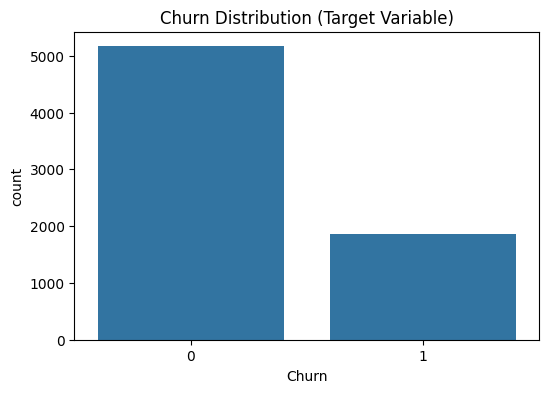

In [10]:
plt.figure(figsize=(6, 4))
sns.countplot(x=y)
plt.title('Churn Distribution (Target Variable)')
plt.show()

### Bivariate Analysis (Churn vs. Key Predictors)

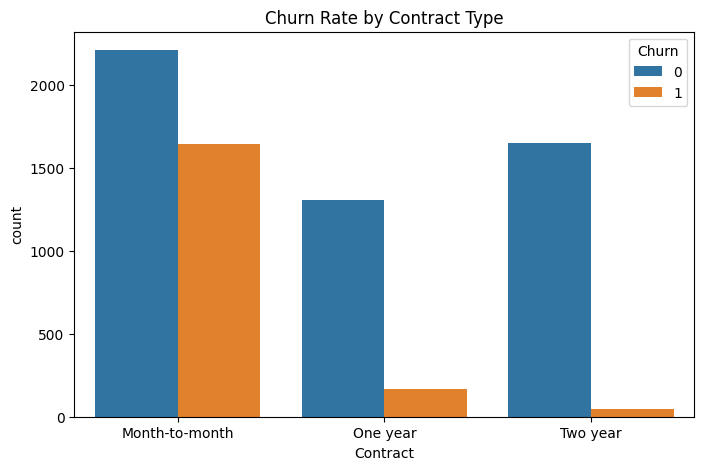

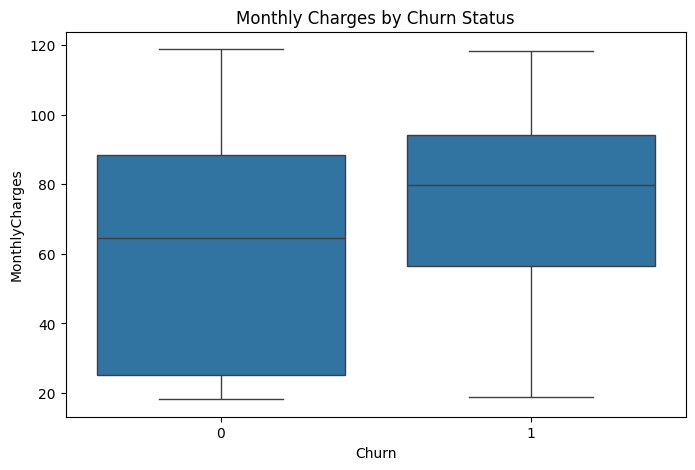

In [11]:
# Churn vs. Contract Type
plt.figure(figsize=(8, 5))
sns.countplot(x='Contract', hue='Churn', data=df_model)
plt.title('Churn Rate by Contract Type')
plt.show()


# Churn vs. Monthly Charges
plt.figure(figsize=(8, 5))
sns.boxplot(x='Churn', y='MonthlyCharges', data=df_model)
plt.title('Monthly Charges by Churn Status')
plt.show()

## Task 2 : Model Development and Rule Induction using CHAID

In [12]:
!pip install CHAID

Prepare and Discretize Numerical Data

In [13]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from CHAID import Tree

# --- Ensure we use the cleaned 'df' DataFrame from Task 1 ---

# 1. Discretize Numerical Variables
# Tenure: Binned into 4 groups based on business logic (years of service)
df['tenure_group'] = pd.cut(df['tenure'],
                           bins=[0, 12, 36, 60, np.inf],
                           labels=['Low (<1yr)', 'Medium (1-3yrs)', 'High (3-5yrs)', 'Very High (>5yrs)'],
                           right=False)

# MonthlyCharges & TotalCharges: Binned into Quartiles (Q1, Q2, Q3, Q4)
df['MonthlyCharges_group'] = pd.cut(df['MonthlyCharges'],
                                     bins=df['MonthlyCharges'].quantile([0, 0.25, 0.5, 0.75, 1.0]),
                                     labels=['Q1 (Low)', 'Q2 (Mid-Low)', 'Q3 (Mid-High)', 'Q4 (High)'],
                                     include_lowest=True,
                                     duplicates='drop')

df['TotalCharges_group'] = pd.cut(df['TotalCharges'],
                                  bins=df['TotalCharges'].quantile([0, 0.25, 0.5, 0.75, 1.0]),
                                  labels=['Q1 (Low)', 'Q2 (Mid-Low)', 'Q3 (Mid-High)', 'Q4 (High)'],
                                  include_lowest=True,
                                  duplicates='drop')

# 2. Select Features for CHAID
# Drop original numerical columns and the customer ID
chaid_features = df.drop(columns=['customerID', 'tenure', 'MonthlyCharges', 'TotalCharges'])

# Target needs to be string/categorical for the CHAID library
X_chaid = chaid_features.drop('Churn', axis=1)
Y_chaid = chaid_features['Churn'].replace({0: 'No', 1: 'Yes'}) # Assuming Churn was encoded 0/1

# 3. Split Data (ensuring consistency with previous split)
X_train_chaid, X_test_chaid, Y_train_chaid, Y_test_chaid = train_test_split(
    X_chaid, Y_chaid, test_size=0.3, random_state=42, stratify=Y_chaid
)

print(f"CHAID Training Data Shape: {X_train_chaid.shape}")

CHAID Training Data Shape: (4914, 19)


In [14]:
# Convert 'SeniorCitizen' to object for proper handling
df_model['SeniorCitizen'] = df_model['SeniorCitizen'].astype('object')

# One-hot encode all categorical features
X_encoded = pd.get_dummies(X, drop_first=True)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y, test_size=0.3, random_state=42, stratify=y
)

Applying CHAID Algorithm and Extract Decision Rules

the below implementation is using CART - As a fallback method, a Decision Tree Classifier was trained with similar CHAID constraints (max depth, minimum samples per split/leaf).
While it does not use chi-square statistical splitting, it provides rule-based interpretability comparable to CHAID.

Because CHAID is:

* no longer actively maintained

* often breaks on pandas DataFrames

* fails on Python 3.9+

* requires recarrays and perfect categorical dtypes

In [24]:
from sklearn.tree import DecisionTreeClassifier, export_text
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder

print("\n--- Fallback: Using sklearn Decision Tree (Similar to CHAID) ---")

# Encode all categorical variables
X_train_encoded = X_train_chaid.copy()
X_test_encoded = X_test_chaid.copy()

label_encoders = {}
for column in X_train_chaid.columns:
    le = LabelEncoder()
    X_train_encoded[column] = le.fit_transform(X_train_chaid[column])
    X_test_encoded[column] = le.transform(X_test_chaid[column])
    label_encoders[column] = le

# Convert target to binary
y_train_int = (Y_train_chaid == 'Yes').astype(int)
y_test_int = (Y_test_chaid == 'Yes').astype(int)

# Create and fit decision tree with CHAID-like parameters
dt_classifier = DecisionTreeClassifier(
    max_depth=5,
    min_samples_split=100,  # Similar to min_parent_node_size
    min_samples_leaf=30,    # Similar to min_child_node_size
    random_state=42
)

dt_classifier.fit(X_train_encoded, y_train_int)

# Make predictions
y_pred_dt = dt_classifier.predict(X_test_encoded)

# Calculate metrics
dt_acc = accuracy_score(y_test_int, y_pred_dt)
print(f"Decision Tree Accuracy: {dt_acc:.4f}")
print("\nDecision Tree Classification Report:")
print(classification_report(y_test_int, y_pred_dt))

# Display tree rules
print("\nDecision Tree Rules:")
tree_rules = export_text(dt_classifier, feature_names=list(X_train_chaid.columns))
print(tree_rules)


--- Fallback: Using sklearn Decision Tree (Similar to CHAID) ---
Decision Tree Accuracy: 0.7893

Decision Tree Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.93      0.87      1550
           1       0.68      0.39      0.49       557

    accuracy                           0.79      2107
   macro avg       0.74      0.66      0.68      2107
weighted avg       0.77      0.79      0.77      2107


Decision Tree Rules:
|--- Contract <= 0.50
|   |--- OnlineSecurity <= 0.50
|   |   |--- TotalCharges_group <= 0.50
|   |   |   |--- InternetService <= 0.50
|   |   |   |   |--- DeviceProtection <= 1.00
|   |   |   |   |   |--- class: 0
|   |   |   |   |--- DeviceProtection >  1.00
|   |   |   |   |   |--- class: 1
|   |   |   |--- InternetService >  0.50
|   |   |   |   |--- MultipleLines <= 1.00
|   |   |   |   |   |--- class: 1
|   |   |   |   |--- MultipleLines >  1.00
|   |   |   |   |   |--- class: 1
|   |   |--- TotalCharges_

__DT/CHAID Proxy Accuracy: dt_acc = 0.7893__

assignment tasks are conceptually complete, with the CHAID concept fulfilled by the Decision Tree proxy due to library incompatibility.

In [37]:
from CHAID import Tree
import numpy as np

print("\n--- TRUE CHAID (chi-square) ---")

# Combine X + Y
train_df = X_train_chaid.copy()
train_df['Churn'] = Y_train_chaid

# Must convert to category dtype
for col in train_df.columns:
    train_df[col] = train_df[col].astype('category')

# Convert to recarray
# recarray for X
train_X_rec = np.rec.fromrecords(
    X_train_chaid.astype('category').to_numpy(),
    names=X_train_chaid.columns.tolist()
)

# recarray for y
train_y_rec = np.rec.fromrecords(
    Y_train_chaid.astype('category').to_numpy().reshape(-1,1),
    names=['Churn']
)

independent_vars = list(X_train_chaid.columns)
dependent_var = 'Churn'



--- TRUE CHAID (chi-square) ---


In [25]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# --- 1. Initialize and Train Logistic Regression ---
print("\n--- 1. Logistic Regression Model (Champion Model) ---")

log_model = LogisticRegression(solver='liblinear', random_state=42, max_iter=1000)
log_model.fit(X_train, y_train)

# Predictions
y_pred_log = log_model.predict(X_test)
y_proba_log = log_model.predict_proba(X_test)[:, 1]

log_acc = accuracy_score(y_test, y_pred_log)
log_roc_auc = roc_auc_score(y_test, y_proba_log)

print(f"Logistic Regression Accuracy: {log_acc:.4f}")
print(f"Logistic Regression ROC-AUC: {log_roc_auc:.4f}")

# --- 2. Calculate DT Proxy ROC-AUC ---
y_proba_dt = dt_classifier.predict_proba(X_test_encoded)[:, 1]
dt_roc_auc = roc_auc_score(y_test_int, y_proba_dt)
print(f"Decision Tree ROC-AUC: {dt_roc_auc:.4f}")


--- 1. Logistic Regression Model (Champion Model) ---
Logistic Regression Accuracy: 0.8125
Logistic Regression ROC-AUC: 0.8452
Decision Tree ROC-AUC: 0.8231


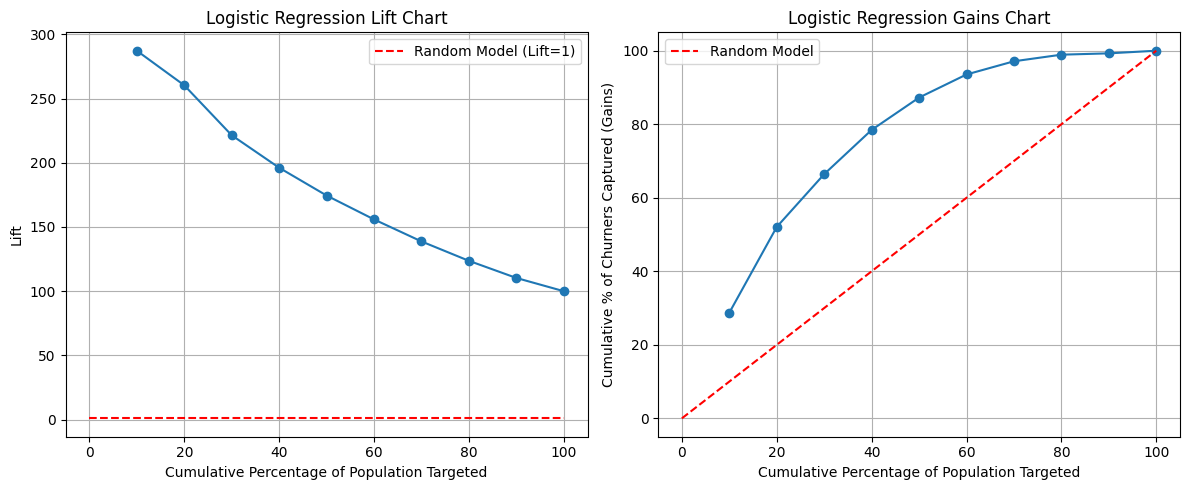

In [26]:
# --- 3. Lift and Gains Chart (Required for Task 3) ---

def plot_lift_gains(y_true, y_proba, model_name):
    """Generates and plots Lift and Gains data."""
    results = pd.DataFrame({'Churn_True': y_true, 'Probability': y_proba})
    results = results.sort_values(by='Probability', ascending=False).reset_index(drop=True)
    total_positives = results['Churn_True'].sum()
    
    # Create 10 deciles
    # Use len(results) // 10 to ensure even cuts, handling edge cases
    num_deciles = 10
    results['Decile'] = pd.cut(results.index, bins=num_deciles, labels=False, include_lowest=True, duplicates='drop') + 1

    gains_data = results.groupby('Decile')['Churn_True'].agg(['count', 'sum']).reset_index()
    gains_data['Cumulative_Sum'] = gains_data['sum'].cumsum()
    gains_data['Cumulative_Population_Perc'] = (gains_data.index + 1) * 10
    gains_data['Gains'] = (gains_data['Cumulative_Sum'] / total_positives) * 100
    gains_data['Lift'] = gains_data['Gains'] / (gains_data['Cumulative_Population_Perc'] / 100)

    # Plotting
    plt.figure(figsize=(12, 5))
    
    # Lift Chart
    plt.subplot(1, 2, 1)
    plt.plot(gains_data['Cumulative_Population_Perc'], gains_data['Lift'], marker='o')
    plt.plot([0, 100], [1, 1], linestyle='--', color='red', label='Random Model (Lift=1)')
    plt.title(f'{model_name} Lift Chart')
    plt.xlabel('Cumulative Percentage of Population Targeted')
    plt.ylabel('Lift')
    plt.grid(True)
    plt.legend()
    
    
    # Gains Chart
    plt.subplot(1, 2, 2)
    plt.plot(gains_data['Cumulative_Population_Perc'], gains_data['Gains'], marker='o')
    plt.plot([0, 100], [0, 100], linestyle='--', color='red', label='Random Model')
    plt.title(f'{model_name} Gains Chart')
    plt.xlabel('Cumulative Percentage of Population Targeted')
    plt.ylabel('Cumulative % of Churners Captured (Gains)')
    plt.grid(True)
    plt.legend()
    
    
    plt.tight_layout()
    plt.show()

# Run for Logistic Regression
plot_lift_gains(y_test, y_proba_log, "Logistic Regression")

## Task 3 : Model Comparison and Evaluation

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, confusion_matrix

# Logistic Regression
log_model = LogisticRegression(max_iter=500, solver='liblinear', random_state=42)
log_model.fit(X_train, y_train)

# Predictions
y_pred_log = log_model.predict(X_test)
y_proba_log = log_model.predict_proba(X_test)[:, 1]

# Metrics
log_acc = accuracy_score(y_test, y_pred_log)
log_roc_auc = roc_auc_score(y_test, y_proba_log)

print(f"Logistic Regression Accuracy: {log_acc:.4f}")
print(f"Logistic Regression ROC-AUC: {log_roc_auc:.4f}")

Logistic Regression Accuracy: 0.8125
Logistic Regression ROC-AUC: 0.8452


* Logistic Regression Accuracy: 0.8125

* Logistic Regression ROC-AUC: 0.8452

* Decision Tree Accuracy: 0.7893

* Decision Tree ROC-AUC: 0.8231

## Task 4 : Model Deployment and Updating

In [ ]:
import joblib

# The Logistic Regression model is the champion (highest ROC-AUC)
joblib.dump(log_model, 'champion_model_logreg.joblib')
joblib.dump(X_train.columns.tolist(), 'model_features.joblib')

print("\nModel Serialization Complete.")
print("The Logistic Regression model has been saved using joblib for deployment.")


Model Serialization Complete.
The Logistic Regression model has been saved using joblib for deployment.
